In [1]:
# Import
import sys
sys.path.append("../src")

from scipy import signal
import scipy

from common import (
    load_config,
    setup_or_load_project, 
    iterate_experiments,
    create_folders,
    def_folders,
    load_conv_results,
    iterate_experiments_filt)
from response_detector import (
    stim_sum_flexible)
from response_tabel_creator import (
    stim_avg_flexible_1d,
    save_stim_to_csv,
    log_stim_quality,
    )
from signal_converter import (
    load_mask)
from visualisation import (
    process_signal,
    summarize_stim_dict_by_type,
    average_stimulus_from_dict,
    save_single_roi_as_bmp,
    apply_mask_and_average,
    average_stim_repeats,
    get_avg_and_error,
    plot_single_panel_signals)

import numpy as np
import napari
import os
import imageio
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import colormaps
import csv

%gui qt

In [2]:
# Change the path here
config_path = r'D:\Analysis_test\config.yaml'
config_stim_path = r'D:\Analysis_test\config_stim.yaml'

res_dir, info_dir, demonstr_dir, result_directory_stim, result_directory_masks = setup_or_load_project(
    config_path=config_path,
    create_func=create_folders,
    def_func=def_folders
)

config = load_config(config_path)
stim_config = load_config(config_stim_path)

In [3]:
# --- Choosing an experiment ---
#experiment_list = list(iterate_experiments(config["all_exp_dir"]))
experiment_list = list(iterate_experiments_filt(config["all_exp_dir"],
                      mice_to_include = config.get("mice_to_include"),
        protocols_to_include = config.get("protocols_to_include"),
        state_to_include = config.get("state_to_include"),
        exp_to_include = config.get("exp_to_include")))

print("Available experiments:\n")
for i, (img_dir, exp, mouse, state, protocol) in enumerate(experiment_list):
    print(f"[{i}] {mouse}_{exp}_{protocol}_{state}")

idx = int(input("\nEnter the experiment number: "))
img_dir, exp, mouse, state, protocol = experiment_list[idx]
print(f"\nЗагружается: {mouse}_{exp}_{protocol}_{state}")

# --- Uploading data ---
filename = f'{mouse}_{exp}_{protocol}_{state}_conv'
Ca_corr, dcHBO, dcHBR, dcHBT, Ca_wocorr = load_conv_results(
    save_path=res_dir / "Conv_signal",
    filename=filename,
    save_format=config['save_format'],
    return_wocorr = True
)

mask = load_mask(res_dir, mouse, exp, protocol, state, config)

Processing experiment day: Example
Found: exp=Example, mouse=m4433, state=Awake, protocol=RV-pulse09
Found: exp=Example, mouse=m8j, state=Awake, protocol=RHL-90mkA
Available experiments:

[0] m4433_Example_RV-pulse09_Awake
[1] m8j_Example_RHL-90mkA_Awake



Enter the experiment number:  0



Загружается: m4433_Example_RV-pulse09_Awake


### Drawing the response mask to sensory stimulation

In [4]:
# --- Compute stim_dict and average across stimuli ---
stim_dict_ca, _ = stim_sum_flexible(
    Ca_corr,
    stim_count=stim_config['stim_count'],
    stim_start_frame=stim_config['stim_start_frame'],
    stim_step=stim_config['stim_step'],
    stim_window=(0, 100),
    subtr_baseline='prestart_mean',  # options: 'mean', 'prestart_mean', 'no'
    subtr_baseline_interval=20,
    substim_count=None,   # Optional: number of substimuli per stimulus
    substim_interval=None,  # Optional: duration between substimuli
    substim_window=(1, 4)
)
avg_ca = average_stimulus_from_dict(stim_dict_ca)  # [T, Y, X]

# --- Apply binary brain mask ---
T, H, W = avg_ca.shape
mask_3d = np.broadcast_to(mask[None, :, :], (T, H, W))
avg_ca_masked = np.where(mask_3d, avg_ca, np.nan)

# --- Normalize to [0, 1] using 1st–99th percentile ---
def norm_3d(img):
    valid = img[np.isfinite(img)]
    p1, p99 = np.percentile(valid, [1, 99])
    img_norm = (img - p1) / (p99 - p1)
    return np.clip(img_norm, 0, 1)

ca_norm = norm_3d(avg_ca_masked)

# --- Display in napari viewer ---
viewer = napari.Viewer()
viewer.add_image(
    ca_norm,
    name="Avg Ca Stimulus",
    colormap="turbo",
    contrast_limits=(0, 1)
)

# --- Add experiment title overlay on all frames ---
experiment_title = f"{mouse}_{exp}_{protocol}_{state}"
title_positions = [[t, -5, W // 2] for t in range(T)]
title_layer = viewer.add_points(title_positions, name='Title', size=0.1)
title_layer.text = {
    'string': [experiment_title] * T,
    'anchor': 'center',
    'color': 'white',
    'size': 28
}

# --- Add ROI drawing layer ---
shapes = viewer.add_shapes(name="ROI", shape_type="polygon")
print("Draw a single ROI. Click 'Quit' to save.")

# --- Run napari event loop ---
napari.run()

Draw a single ROI. Click 'Quit' to save.


In [5]:
# --- ROI after napari.run() ---
roi_layer = None
for layer in viewer.layers:
    if isinstance(layer, napari.layers.Shapes):
        roi_layer = layer
        break

# --- Path to save ROI and CSV log ---
roi_dir = res_dir / 'ResponseMasks_Drawn'
roi_dir.mkdir(parents=True, exist_ok=True)
bmp_path = roi_dir / f"{mouse}_{exp}_{protocol}_{state}_roi.bmp"

# --- CSV log path ---
csv_path = info_dir / "roi_mask_log.csv"
csv_exists = os.path.exists(csv_path)

# --- Process ROI and save ---
if roi_layer is None or len(roi_layer.data) == 0:
    print("ROI not drawn!")
    answer_mask = 0
else:
    # Get mask from shape and save it
    roi_mask = roi_layer.to_labels([H, W]).astype(np.uint8)
    Image.fromarray(roi_mask * 255).save(bmp_path)
    print(f"ROI mask saved: {bmp_path}")
    answer_mask = 1

# --- Write to CSV ---
with open(csv_path, mode='a', newline='') as f:
    writer = csv.writer(f)
    if not csv_exists:
        writer.writerow(["mouse", "exp", "protocol", "state", "answer_mask"])  # header
    writer.writerow([mouse, exp, protocol, state, answer_mask])
    print(f"📝 CSV updated: {csv_path}")

ROI mask saved: D:\Analysis_test\Main_analysis_2025-07-20\ResponseMasks_Drawn\m4433_Example_RV-pulse09_Awake_roi.bmp
📝 CSV updated: D:\Analysis_test\Main_analysis_2025-07-20\Info\roi_mask_log.csv


### Visualizing the response on the plot

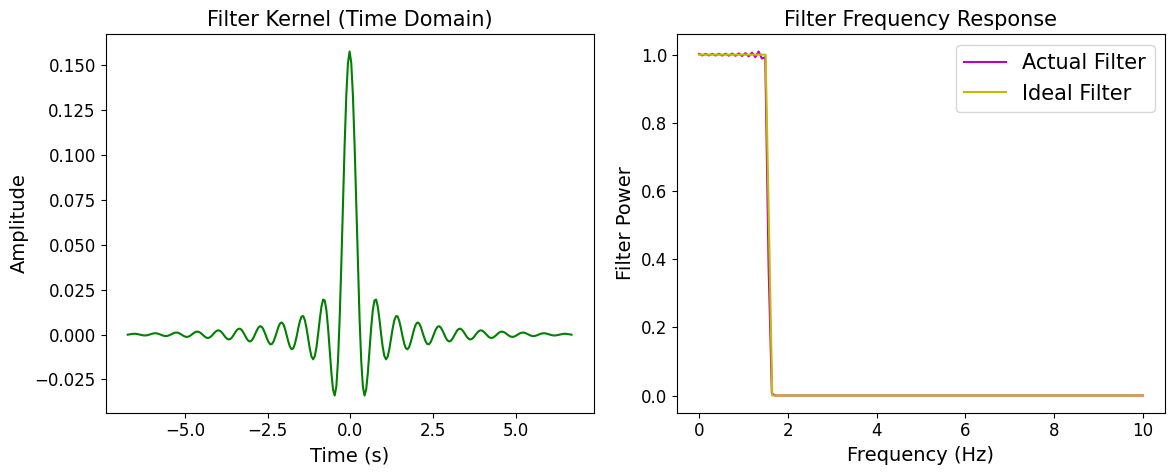

In [6]:
# Create filter kernel for frequency-based filtering (low-pass)
sampling_rate = 20  # Hz
cutoff_freq = 1.5   # Hz
transition_width = 0.1
filter_order = int(np.round(20 * sampling_rate / cutoff_freq)) + 1

# Ensure filter order is odd
if filter_order % 2 == 0:
    filter_order += 1

# Define desired frequency response shape
desired_shape = [1, 1, 0, 0]
frequency_points = [
    0,
    cutoff_freq,
    cutoff_freq + cutoff_freq * transition_width,
    sampling_rate / 2
]

# Design filter kernel using least-squares method
filter_kernel = signal.firls(
    filter_order,
    frequency_points,
    desired_shape,
    fs=sampling_rate
)

# Compute power spectrum of the filter (frequency response)
filter_power = np.abs(scipy.fftpack.fft(filter_kernel)) ** 2
hz = np.linspace(0, sampling_rate / 2, int(np.floor(len(filter_kernel) / 2) + 1))
filter_power = filter_power[:len(hz)]

# Plot the filter kernel and frequency response
plt.figure(figsize=(12, 5))

# Plot the filter kernel (time domain)
plt.subplot(121)
plt.plot(np.arange(-filter_order / 2, filter_order / 2) / sampling_rate, filter_kernel, color='g')
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.title('Filter Kernel (Time Domain)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Plot the frequency response
plt.subplot(122)
plt.plot(hz, filter_power, 'm', label='Actual Filter')
plt.plot(np.array(frequency_points), desired_shape, 'y', label='Ideal Filter')
plt.xlabel('Frequency (Hz)', fontsize=14)
plt.ylabel('Filter Power', fontsize=14)
plt.title('Filter Frequency Response', fontsize=15)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

ROI mask shape: (64, 87)
Ca_corr (ROI averaged) shape: (8800,)


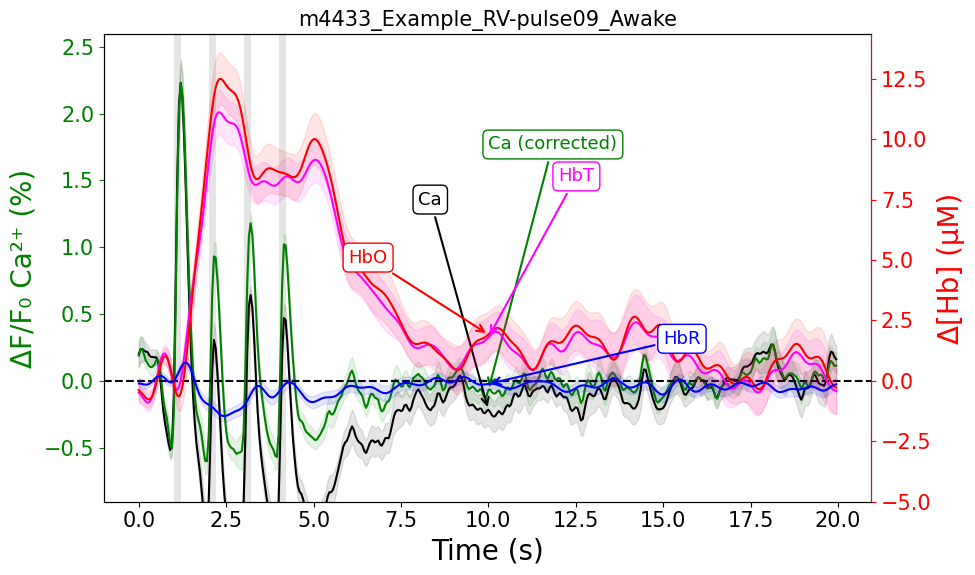

In [7]:
# --- Load ROI mask ---
# BMP or PNG: make sure the mask is binary (0 and 255)
mask_path = res_dir / 'ResponseMasks_Drawn' / f"{mouse}_{exp}_{protocol}_{state}_roi.bmp"
roi_mask = np.array(Image.open(mask_path)) > 0  # binarize if needed

# Check shape
print(f"ROI mask shape: {roi_mask.shape}")  # (H, W)

# --- Compute signals within ROI ---
signal_ca_corr   = apply_mask_and_average(Ca_corr, roi_mask)
signal_ca_wocorr = apply_mask_and_average(Ca_wocorr, roi_mask)
signal_dhbo    = apply_mask_and_average(dcHBO, roi_mask)
signal_dhbr    = apply_mask_and_average(dcHBR, roi_mask)
signal_dhbt      = apply_mask_and_average(dcHBT, roi_mask)

# Apply filtering to the HbT signal (optional for HbO, HbR if uncommented)
signal_dhbt = signal.filtfilt(filter_kernel, 1, signal_dhbt, axis=0)
signal_dhbo = signal.filtfilt(filter_kernel, 1, signal_dhbo, axis=0)
signal_dhbr = signal.filtfilt(filter_kernel, 1, signal_dhbr, axis=0)

stim_type = protocol.split('-')[0]
stim_cfg = stim_config['stim_1d']

# --- Save ROI-averaged traces (without CSV export) ---
process_signal(signal_ca_corr, "Ca", result_directory_stim / 'Drawn_ReaspnseMasks', mouse, protocol, exp, state, stim_type, stim_cfg, save_csv=False)
process_signal(signal_ca_wocorr, "Cawocorr", result_directory_stim / 'Drawn_ReaspnseMasks', mouse, protocol, exp, state, stim_type, stim_cfg, save_csv=False)
process_signal(signal_dhbt, "dcHbT", result_directory_stim / 'Drawn_ReaspnseMasks', mouse, protocol, exp, state, stim_type, stim_cfg, save_csv=False)
process_signal(signal_dhbo, "dcHbO", result_directory_stim / 'Drawn_ReaspnseMasks', mouse, protocol, exp, state, stim_type, stim_cfg, save_csv=False)
process_signal(signal_dhbr, "dcHbR", result_directory_stim / 'Drawn_ReaspnseMasks', mouse, protocol, exp, state, stim_type, stim_cfg, save_csv=False)

# --- Output shape of Ca trace ---
print(f"Ca_corr (ROI averaged) shape: {signal_ca_corr.shape}")  # (T,)

# --- Plot response curves ---
plot_single_panel_signals(
    signal_ca_corr * 100,          # scaled for display
    signal_ca_wocorr * 100,
    signal_dhbo*1e6,
    signal_dhbr*1e6,
    signal_dhbt*1e6,
    fps=20,
    pattern_start_sec=16,
    pattern_length_sec=20,
    pre_stim_sec=1,
    title=f'{mouse}_{exp}_{protocol}_{state}',
    error_type='sem',              # or 'sd', or 'none'
    label_position='center',       # or 'left', 'right'
    save_path=result_directory_stim / f"{mouse}_{exp}_{protocol}_{state}_answer.tiff"
)